# ClimateDISK: Hockey stick

This notebook attempts to follow the WINGS steps necessary to reproduce the hockey stick figure (and allow for upgrades as new data becomes available).

Let's first import our favorite packages:

In [1]:
import json
import requests
import pandas as pd
import io
import ast
import numpy as np
import pyleoclim as pyleo
import seaborn as sns
import cfr as cfr

## Step 1: Data query

For now let's query the LiPDverse v3 graph directly. For ClimateDisk, we may need to return the datasets URL, send the datasets to WINGS and use PyLiPD in the first component to produce the DataFrame.

In [2]:
url = 'https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse3'

query = """PREFIX le: <http://linked.earth/ontology#>
PREFIX wgs84: <http://www.w3.org/2003/01/geo/wgs84_pos#>


SELECT ?dataSetName ?archiveType ?geo_meanLat ?geo_meanLon ?geo_meanElev 
    ?paleoData_variableName ?paleoData_values ?paleoData_units 
    ?paleoData_proxy ?paleoData_proxyGeneral ?time_variableName ?time_values 
	?time_units ?compilationName ?TSID where{
    
    ?ds a le:Dataset .
    ?ds le:name ?dataSetName .
    OPTIONAL{?ds le:proxyArchiveType ?archiveType .}
    
    ?ds le:collectedFrom ?loc .
    ?loc wgs84:lat ?geo_meanLat .
    ?loc wgs84:long ?geo_meanLon .
    OPTIONAL {?loc wgs84:alt ?geo_meanElev .}
    
    ?ds le:includesPaleoData ?data .
    ?data le:foundInMeasurementTable ?table .
    ?table le:includesVariable ?var . 
    ?var le:name ?paleoData_variableName .
    ?var le:hasValues ?paleoData_values .
    OPTIONAL{?var le:hasUnits ?paleoData_units .}
    OPTIONAL{?var le:proxy ?paleoData_proxy .}
    OPTIONAL{?var le:proxyGeneral ?paleoData_proxyGeneral .}
    ?var le:partOfCompilation ?compilation . 
    ?compilation le:name ?compilationName .
    VALUES ?compilationName {"iso2k" "Pages2kTemperature"} .
    ?var le:useInGlobalTemperatureAnalysis True .
    OPTIONAL{?var le:hasVariableID ?TSID} .
    
    
    ?table le:includesVariable ?timevar .
    ?timevar le:name ?time_variableName .
    FILTER (regex(?time_variableName, "year.*")).
    ?timevar le:hasValues ?time_values .
    OPTIONAL{?timevar le:hasUnits ?time_units .}
    
}"""

In [3]:
response = requests.post(url, data = {'query': query})

data = io.StringIO(response.text)
df = pd.read_csv(data, sep=",")

df['paleoData_values']=df['paleoData_values'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)
df['time_values']=df['time_values'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)

df.head()

,dataSetName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_values,time_units,compilationName,TSID
0,LS16STCL,LakeSediment,50.830,-116.39,1126.0,d18O,"[-7.81, -5.91, -9.03, -5.35, -5.61, -5.98, -5....",permil,d18O,NaN,year,"[2009.0, 2008.3, 2007.8, 2007.4, 2007.0, 2006....",AD,iso2k,LPD7dc5b9ba
1,CO00URMA,Coral,0.933,173.00,6.0,d18O,"[-4.8011, -4.725, -4.6994, -4.86, -5.0886, -5....",permil,d18O,NaN,year,"[1994.5, 1994.33, 1994.17, 1994.0, 1993.83, 19...",AD,iso2k,Ocean2kHR_177
2,CO00URMA,Coral,0.933,173.00,6.0,d18O,"[-4.8011, -4.725, -4.6994, -4.86, -5.0886, -5....",permil,d18O,NaN,year,"[1994.5, 1994.33, 1994.17, 1994.0, 1993.83, 19...",AD,iso2k,Ocean2kHR_177
3,CO00URMA,Coral,0.933,173.00,6.0,d18O,"[-4.8011, -4.725, -4.6994, -4.86, -5.0886, -5....",permil,d18O,NaN,year,"[1994.5, 1994.33, 1994.17, 1994.0, 1993.83, 19...",AD,iso2k,Ocean2kHR_177
4,CO05KUBE,Coral,32.467,-64.70,-12.0,d18O,"[-4.15, -3.66, -3.69, -4.07, -3.95, -4.12, -3....",permil,d18O,NaN,year,"[1983.21, 1983.13, 1983.04, 1982.96, 1982.88, ...",AD,iso2k,Ocean2kHR_105


In [4]:
"The number of records is "+str(len(df.index))

'The number of records is 656'

In [5]:
df.columns

Index(['dataSetName', 'archiveType', 'geo_meanLat', 'geo_meanLon',
       'geo_meanElev', 'paleoData_variableName', 'paleoData_values',
       'paleoData_units', 'paleoData_proxy', 'paleoData_proxyGeneral',
       'time_variableName', 'time_values', 'time_units', 'compilationName',
       'TSID'],
      dtype='object')

## Step 2: Remove duplicate rows

To be considered a duplicate:
1. Have the same `TSID`
2. Have the same `paleoData_variableName`
3. Have the same `paleoData_values`
4. Have the same `time_values`

In [6]:
def is_duplicate(row1,row2):
    if row1['TSID']==row2['TSID']:
        if row1['paleoData_variableName']==row2['paleoData_variableName']:
            if len(row1['paleoData_values']) != len(row2['paleoData_values']):
                equal=False
            else:
                if np.allclose(row1['paleoData_values'], row2['paleoData_values'], atol=0.001)==True:
                    if len(row1['time_values']) != len(row2['time_values']):
                        equal=False
                    else:
                        if np.allclose(row1['time_values'], row2['time_values'], atol=0.001)==True:
                            equal = True
                        else: equal=False
                else:
                    equal=False
        else:
            equal=False    
    else:
        equal = False
    return equal

In [7]:
tsid = df['TSID'].unique()

idx_list = []

for item in tsid:
    df1=df[df['TSID']==item]
    if len(df1.index)>1:
        comp = df1.iloc[0]
        df2 = df1.iloc[1:]

        for index, row in df2.iterrows():
            if is_duplicate(comp,row)==True:
                idx_list.append(index)

df_nodup = df.drop(idx_list)

In [8]:
"There is now "+ str(len(df_nodup.index)) + " timeseries available."

'There is now 612 timeseries available.'

## Step 2: Slice for the time frame of interest

We can use Pyleoclim to do this for us

In [9]:
time_slice = []
value_slice = []

for _,row in df_nodup.iterrows():
    ts=pyleo.Series(time = row['time_values'],
                    value = row ['paleoData_values'],
                    time_name = row ['time_variableName'],
                    time_unit = row ['time_units'],
                    value_name = row ['paleoData_variableName'],
                    value_unit = row['paleoData_units'], verbose=False)
    ts_slice = ts.slice([0,2000])
    time_slice.append(ts_slice.time)
    value_slice.append(ts_slice.value)

In [10]:
df_nodup['time_values_slice']=time_slice
df_nodup['paleoData_values_slice'] = value_slice

In [11]:
df_nodup.head()

,dataSetName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_values,time_units,compilationName,TSID,time_values_slice,paleoData_values_slice
0,LS16STCL,LakeSediment,50.8300,-116.3900,1126.0,d18O,"[-7.81, -5.91, -9.03, -5.35, -5.61, -5.98, -5....",permil,d18O,NaN,year,"[2009.0, 2008.3, 2007.8, 2007.4, 2007.0, 2006....",AD,iso2k,LPD7dc5b9ba,"[0.299999999999955, 2.90000000000009, 5.700000...","[-5.36, -5.34, -5.12, -5.19, -5.34, -5.32, -6...."
1,CO00URMA,Coral,0.9330,173.0000,6.0,d18O,"[-4.8011, -4.725, -4.6994, -4.86, -5.0886, -5....",permil,d18O,NaN,year,"[1994.5, 1994.33, 1994.17, 1994.0, 1993.83, 19...",AD,iso2k,Ocean2kHR_177,"[1840.0, 1840.17, 1840.33, 1840.5, 1840.67, 18...","[-4.6914, -4.7834, -4.5927, -4.3615, -4.315, -..."
4,CO05KUBE,Coral,32.4670,-64.7000,-12.0,d18O,"[-4.15, -3.66, -3.69, -4.07, -3.95, -4.12, -3....",permil,d18O,NaN,year,"[1983.21, 1983.13, 1983.04, 1982.96, 1982.88, ...",AD,iso2k,Ocean2kHR_105,"[1825.21, 1825.29, 1825.38, 1825.46, 1825.54, ...","[-3.1, -3.2, -3.37, -3.79, -3.94, -3.88, -3.74..."
5,IC13THQU,GlacierIce,-13.9333,-70.8333,5670.0,d18O,"[-18.5905, -16.3244, -16.2324, -17.0112, -18.6...",permil,d18O,NaN,year,"[2009, 2008, 2007, 2006, 2005, 2004, 2003, 200...",AD,iso2k,SAm_035,"[226.0, 227.0, 228.0, 229.0, 230.0, 231.0, 232...","[-18.12, -17.48, -17.33, -17.84, -18.45, -18.8..."
6,CO01TUNG,Coral,-5.2170,145.8170,-3.0,d18O,"[-4.827, -4.786, -4.693, -4.852, -4.991, -4.90...",permil,d18O,NaN,year,"[1993.042, 1992.792, 1992.542, 1992.292, 1992....",AD,iso2k,Ocean2kHR_140,"[1880.792, 1881.042, 1881.292, 1881.542, 1881....","[-4.801, -4.94, -4.906, -4.792, -4.923, -5.023..."


## Step 3: Gaussianize

Let's have Pyleoclim help us with that

In [12]:
value_gaussianize = []

for _,row in df_nodup.iterrows():
    ts=pyleo.Series(time = row['time_values_slice'],
                    value = row ['paleoData_values_slice'],
                    time_name = row ['time_variableName'],
                    time_unit = row ['time_units'],
                    value_name = row ['paleoData_variableName'],
                    value_unit = row['paleoData_units'], verbose=False)
    ts_g = ts.gaussianize()
    value_gaussianize.append(ts_g.value)

In [13]:
df_nodup['paleoData_values_slice_gauss'] = value_gaussianize

In [14]:
df_nodup.head()

,dataSetName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_values,time_units,compilationName,TSID,time_values_slice,paleoData_values_slice,paleoData_values_slice_gauss
0,LS16STCL,LakeSediment,50.8300,-116.3900,1126.0,d18O,"[-7.81, -5.91, -9.03, -5.35, -5.61, -5.98, -5....",permil,d18O,NaN,year,"[2009.0, 2008.3, 2007.8, 2007.4, 2007.0, 2006....",AD,iso2k,LPD7dc5b9ba,"[0.299999999999955, 2.90000000000009, 5.700000...","[-5.36, -5.34, -5.12, -5.19, -5.34, -5.32, -6....","[-0.2130875894530718, -0.17422655914690632, 0...."
1,CO00URMA,Coral,0.9330,173.0000,6.0,d18O,"[-4.8011, -4.725, -4.6994, -4.86, -5.0886, -5....",permil,d18O,NaN,year,"[1994.5, 1994.33, 1994.17, 1994.0, 1993.83, 19...",AD,iso2k,Ocean2kHR_177,"[1840.0, 1840.17, 1840.33, 1840.5, 1840.67, 18...","[-4.6914, -4.7834, -4.5927, -4.3615, -4.315, -...","[-0.9811705980359124, -1.2651460843379647, -0...."
4,CO05KUBE,Coral,32.4670,-64.7000,-12.0,d18O,"[-4.15, -3.66, -3.69, -4.07, -3.95, -4.12, -3....",permil,d18O,NaN,year,"[1983.21, 1983.13, 1983.04, 1982.96, 1982.88, ...",AD,iso2k,Ocean2kHR_105,"[1825.21, 1825.29, 1825.38, 1825.46, 1825.54, ...","[-3.1, -3.2, -3.37, -3.79, -3.94, -3.88, -3.74...","[1.328615981030611, 0.9458448462285661, 0.4131..."
5,IC13THQU,GlacierIce,-13.9333,-70.8333,5670.0,d18O,"[-18.5905, -16.3244, -16.2324, -17.0112, -18.6...",permil,d18O,NaN,year,"[2009, 2008, 2007, 2006, 2005, 2004, 2003, 200...",AD,iso2k,SAm_035,"[226.0, 227.0, 228.0, 229.0, 230.0, 231.0, 232...","[-18.12, -17.48, -17.33, -17.84, -18.45, -18.8...","[-0.24533483270695292, 0.3501885714345531, 0.5..."
6,CO01TUNG,Coral,-5.2170,145.8170,-3.0,d18O,"[-4.827, -4.786, -4.693, -4.852, -4.991, -4.90...",permil,d18O,NaN,year,"[1993.042, 1992.792, 1992.542, 1992.292, 1992....",AD,iso2k,Ocean2kHR_140,"[1880.792, 1881.042, 1881.292, 1881.542, 1881....","[-4.801, -4.94, -4.906, -4.792, -4.923, -5.023...","[0.7315480859971977, 0.03064136195287292, 0.21..."


## Step 4: Create the composite

### Step 4a: Clean up the proxy/variable names

In [15]:
temp = df_nodup[['archiveType','paleoData_variableName']]

temp.groupby(['archiveType','paleoData_variableName'], as_index=False).value_counts()

,archiveType,paleoData_variableName,count
0,Coral,d18O,45
1,GlacierIce,d18O,1
2,LakeSediment,d18O,3
3,LakeSediment,d2H,1
4,Sclerosponge,d18O,3
5,bivalve,d18O,1
6,borehole,temperature,2
7,coral,Sr_Ca,24
8,coral,calcification,2
9,coral,composite,6


Get the standard archive and variable names:

In [16]:
archive_std = pd.read_csv('archiveType.csv')
df_archive = archive_std[['lipdName','synonym']].reset_index()

syn = []
for _,row in df_archive.iterrows():
    syn.append(row['synonym'].lower().replace(' ',""))
df_archive['synonym_reg']=syn

var_std=pd.read_csv('paleoData_variableName.csv')
df_var = var_std[['lipdName','synonym']].reset_index()

syn_var=[]
for _,row in df_var.iterrows():
    try:
        syn_var.append(row['synonym'].lower().replace(' ',"").replace('/',"").replace('_',""))
    except:
        syn_var.append(row['synonym'])
df_var['synonym_reg']=syn_var

In [17]:
#let's do the archive first

archiveType_lipd = []

for _, row in df_nodup.iterrows():
    match = row['archiveType'].lower().replace(' ',"").replace('/',"").replace('_',"")
    f = df_archive[df_archive['synonym_reg']==match]
    if type(f) == pd.core.frame.DataFrame and not f.empty:
        archiveType_lipd.append(f['lipdName'].iloc[0])
    elif type(f) == pd.core.series.Series:
        archiveType_lipd.append(f['lipdName'])
    else:
        archiveType_lipd.append(row['archiveType'])

In [18]:
#let's work on varname

variableName = []

for _, row in df_nodup.iterrows():
    match = row['paleoData_variableName'].lower().replace(' ',"").replace('/',"").replace('_',"")
    f = df_var[df_var['synonym_reg']==match]
    if type(f) == pd.core.frame.DataFrame and not f.empty:
        variableName.append(f['lipdName'].iloc[0])
    elif type(f) == pd.core.series.Series:
        variableName.append(f['lipdName'])
    else:
        variableName.append(row['archiveType'])

In [19]:
ptype = []
for idx,item in enumerate(variableName):
    ptype.append(archiveType_lipd[idx]+'.'+item)    

Put it in our DataFrame:

In [20]:
df_nodup['ptype']=ptype

### Step 4b: Set the style for the figures

In [21]:
colors_dict = {}

for idx, item in enumerate(set(ptype)):
    if 'marinesediment' in item.lower():
        colors_dict[item] = sns.xkcd_rgb['brown']
    elif 'lakesediment' in item.lower():
        colors_dict[item]= sns.xkcd_rgb['maroon']
    elif 'coral' in item.lower():
        colors_dict[item]= sns.xkcd_rgb['orange']
    elif 'ice' in item.lower():
        colors_dict[item]= sns.xkcd_rgb['sky blue']
    elif 'borehole' in item.lower():
        colors_dict[item]= sns.xkcd_rgb['dark blue']
    elif 'sclerosponge' in item.lower():
        colors_dict[item]= sns.xkcd_rgb['amber']
    elif 'speleothem' in item.lower():
        colors_dict[item]= sns.xkcd_rgb['mauve']
    elif 'wood' in item.lower():
        colors_dict[item]= sns.xkcd_rgb['forest green']
    elif 'bivalve' in item.lower():
        colors_dict[item]= sns.xkcd_rgb['peach']
    else:
        colors_dict[item]= 'k'  

In [22]:
markers_dict = {}

for idx, item in enumerate(set(ptype)):
    if 'temperature' in item.lower():
        markers_dict[item] = 'P'
    elif 'srca' in item.lower().replace('/',''):
        markers_dict[item]= 'X'
    elif 'd18o' in item.lower():
        markers_dict[item] = 'o'
    elif 'calcification' in item.lower():
        markers_dict[item] = 'H'
    elif 'composite' in item.lower():
        markers_dict[item] = '<'
    elif 'd2h' in item.lower():
        markers_dict[item] = 'd'
    elif 'reflectance' in item.lower():
        markers_dict[item] = '>'
    elif 'thickness' in item.lower():
        markers_dict[item] = 'h'
    elif 'mxd' in item.lower():
        markers_dict[item] = '8'
    elif 'density' in item.lower():
        markers_dict[item] = '^'
    elif 'width' in item.lower():
        markers_dict[item] = 'v'
    else:
        markers_dict[item] = 's'

Reset the plotting style:

In [23]:
cfr.visual.STYLE.colors_dict = colors_dict
cfr.visual.STYLE.markers_dict = markers_dict

### Step 4c: Create the Proxy DataBase

Let's try to get one ProxyRecord into `cfr`:

In [24]:
row = df_nodup.iloc[0,:]

f = cfr.ProxyRecord(pid = row['TSID'],
                   time = row['time_values_slice'],
                   value = row['paleoData_values_slice_gauss'],
                   lat = row['geo_meanLat'],
                   lon = row['geo_meanLon'],
                   elev = row['geo_meanElev'],
                   ptype = row['ptype'],
                   tags = None,
                   value_name = row['paleoData_variableName'],
                   value_unit = row['paleoData_units'],
                   time_name = row['time_units'],
                   seasonality = None)

(<Figure size 1200x400 with 2 Axes>,
 {'ts': <AxesSubplot: title={'center': 'LPD7dc5b9ba (LakeSediment.d18O) @ (lat:50.83, lon:243.61)'}, xlabel='AD [yr]', ylabel='d18O [permil]'>,
  'map': <GeoAxesSubplot: >})

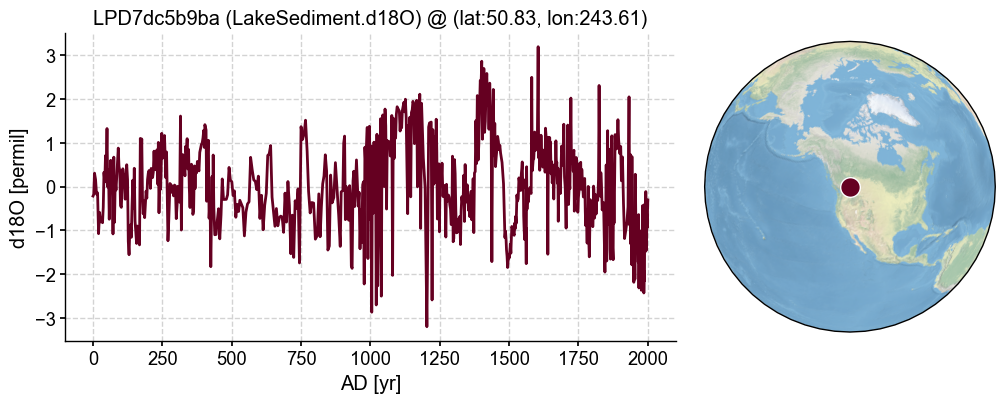

In [25]:
f.plot()

Now let's try to get the proxy database sorted out:

In [26]:
proxy_dict = {}

for _,row in df_nodup.iterrows():
    proxy_dict[row['TSID']] = cfr.ProxyRecord(pid = row['TSID'],
                   time = row['time_values_slice'],
                   value = row['paleoData_values_slice_gauss'],
                   lat = row['geo_meanLat'],
                   lon = row['geo_meanLon'],
                   elev = row['geo_meanElev'],
                   ptype = row['ptype'],
                   tags = None,
                   value_name = row['paleoData_variableName'],
                   value_unit = row['paleoData_units'],
                   time_name = row['time_units'],
                   seasonality = None)

In [27]:
pdb = cfr.ProxyDatabase(proxy_dict)

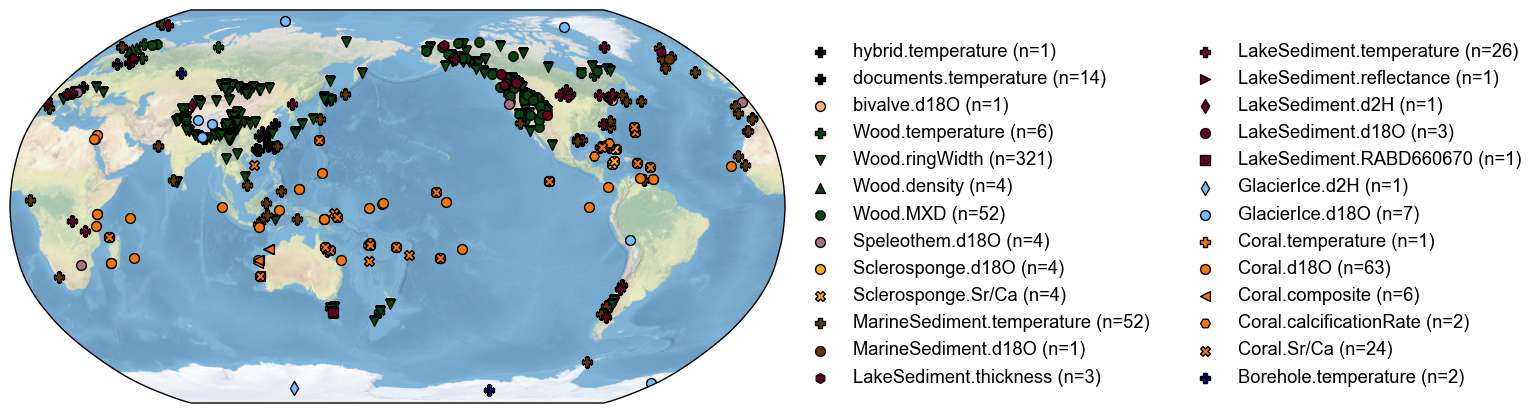

In [28]:
fig, ax = pdb.plot()

### Step 4d: Calibrate against instrumental data

In [29]:
import xarray as xr

ds = xr.open_dataset('./data/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
ds

<xarray.Dataset>
Dimensions:           (time: 2071, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-07-1...
  * latitude          (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude         (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
    realization       int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, latitude, longitude) float64 ...
    time_bnds         (time, bnds) datetime64[ns] ...
    latitude_bnds     (latitude, bnds) float64 ...
    longitude_bnds    (longitude, bnds) float64 ...
    realization_bnds  (bnds) int64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2022-09-06T13:35:49+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

In [30]:
obs = cfr.ClimateField().load_nc(
    './data/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc',
    vn='tas_mean', lat_name='latitude', lon_name='longitude',
)
obs = obs.rename('tas')

### Step 4e: make the composite

In [31]:
pdb.make_composite(obs,bin_width=10)

Analyzing ProxyRecord:   0%|                            | 0/605 [00:00<?, ?it/s]/Users/deborahkhider/opt/anaconda3/envs/paleopandas/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/deborahkhider/opt/anaconda3/envs/paleopandas/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Analyzing ProxyRecord:   1%|▏                   | 7/605 [00:01<02:07,  4.68it/s]/Users/deborahkhider/opt/anaconda3/envs/paleopandas/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/deborahkhider/opt/anaconda3/envs/paleopandas/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Analyzing ProxyRecord:   4%|▊                  | 25/605 

Text(0.5, 1.0, 'Multi-Proxy,  605 records, bin_width=10')

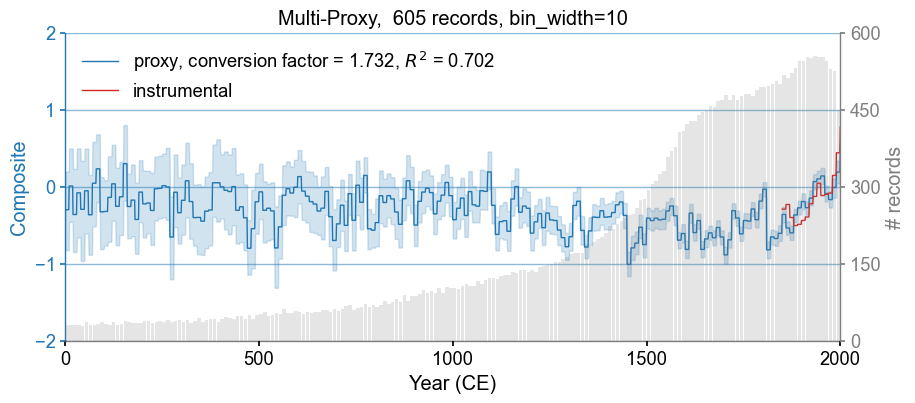

In [60]:
fig, ax = pdb.plot_composite()
current_title = ax['var'].title.get_text().split(',',1)[-1]
ax['var'].set_title('Multi-Proxy, '+current_title)